Osnabrück University - Computer Vision (Winter Term 2018/19) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack, Axel Schaffland

# Exercise Sheet 05: Segmentation 2

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, December 9, 2018**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (Periodic functions) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What are periodic functions? Can you provide a definition?

YOUR ANSWER HERE

**b)** What are *amplitude*, *frequency*, *wave length*, and *phase* of a sine function? How can you change these properties?

YOUR ANSWER HERE

**c)** How are sine and cosine defined for complex arguments? In what sense does this generalize the real case?

YOUR ANSWER HERE

## Assignment 1: Edge-based segmentation  [5 Points]

### a) Edge linking

Describe in your own words the idea of edge linking. What is the goal? Why does it not necessarily yield closed
edge contours?

Edge linking tries to link disconnected edges by searching for other pixels (relative to a start pixel) that have a similar gradient direction and magnitude. Those pixels are then linked and marked as belonging to the same edge.

### b) Zero crossings

Explain what zero crossings are. Why does the detection of zero crossings always lead to closed contours?

Zero crossings are the where the values of a function (in our case an image) changes its sign, so the always lie on the contour of an object. Therefore, detecting zero crossings always leads to a closed contour.

### c) Zero crossings (implementation)

Provide an implementation of the zero crossing procedure described in (CV-07 slide 71). To get sensible results you should smooth the image before applying the Laplacian filter, e.g. using the Laplacian of a Gaussian (you may use buildin functions for the filterings steps).

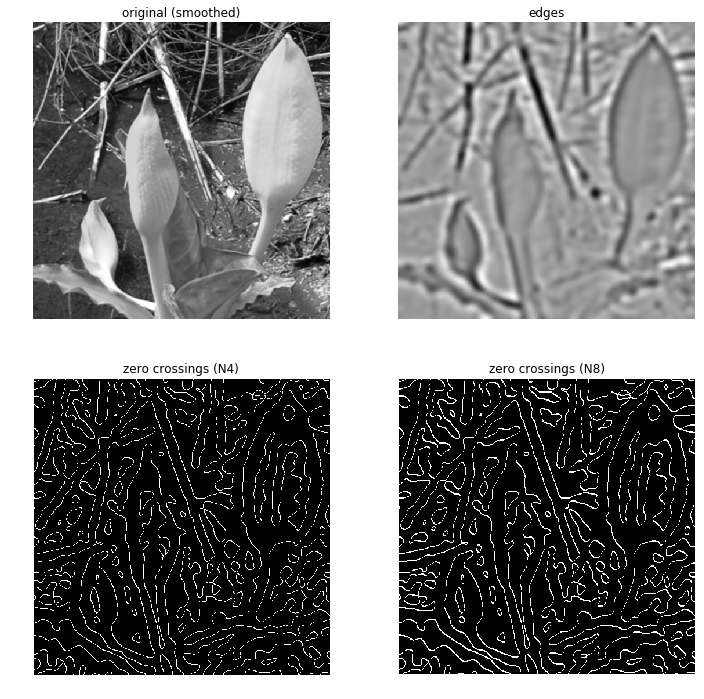

In [96]:
from skimage import filters, io
import matplotlib.pyplot as plt
from scipy import ndimage as nd
import numpy as np
%matplotlib inline

img = io.imread('images/swampflower.png')

def calc_edges(img, sigma=7):
    return nd.gaussian_laplace(img, sigma=sigma)

def zero_crossings(edges, neighborhood=4):
    shifted_x = np.zeros(edges.shape)
    shifted_y = shifted_x.copy()
    shifted_xy1 = shifted_x.copy()
    shifted_xy2 = shifted_x.copy()
    # Shift edges image
    shifted_x[:, 1:] = edges[:,:-1]
    shifted_y[1:, :] = edges[:-1,:]
    shifted_xy1[:-1, 1:] = edges[1:,:-1]
    shifted_xy2[1:, 1:] = edges[1:,:-1]
    # Result image
    result = np.zeros(edges.shape)
    
    if neighborhood == 8:
        result[(edges * shifted_x <= 0) | (edges * shifted_y <= 0) | \
               (edges * shifted_xy1 <= 0)| (edges * shifted_xy2 <= 0)] = 1
    else:
        result [(edges * shifted_x <= 0) | (edges * shifted_y <= 0)] = 1
        
    return result

# Smooth the image
smooth_img = filters.gaussian(img, sigma=1)
# Find edges
edges = calc_edges(smooth_img)
# Calculate zero crossings
zero_crossings_n4 = zero_crossings(edges, 4)
zero_crossings_n8 = zero_crossings(edges, 8)

plt.figure(figsize=(12, 12))
plt.gray()

plt.subplot(2,2,1); plt.axis('off'); plt.imshow(smooth_img); plt.title('original (smoothed)')
plt.subplot(2,2,2); plt.axis('off'); plt.imshow(edges); plt.title('edges')
plt.subplot(2,2,3); plt.axis('off'); plt.imshow(zero_crossings_n4); plt.title('zero crossings (N4)')
plt.subplot(2,2,4); plt.axis('off'); plt.imshow(zero_crossings_n8); plt.title('zero crossings (N8)' )

plt.show()

## Assignment 2: Watershed transform  [5 Points]



### a) Watershed transform

Explain in your own words the idea of watershed transform. How do the two different approaches from the lecture work? Why does watershed transform always give a closed contour?



YOUR ANSWER HERE

### b) Implementation

Now implement the watershed transform using the flooding approach (CV-07 slide 76, but note, that the algorithm presented there is somewhat simplified!). Obviously, buildins for computing watershed transform are not allowed, but all other functions may be used. In this example we appply the watershed transform to a distance transformed image, so you **do not** have to take the gradient image, but can apply the watershed transform directly.

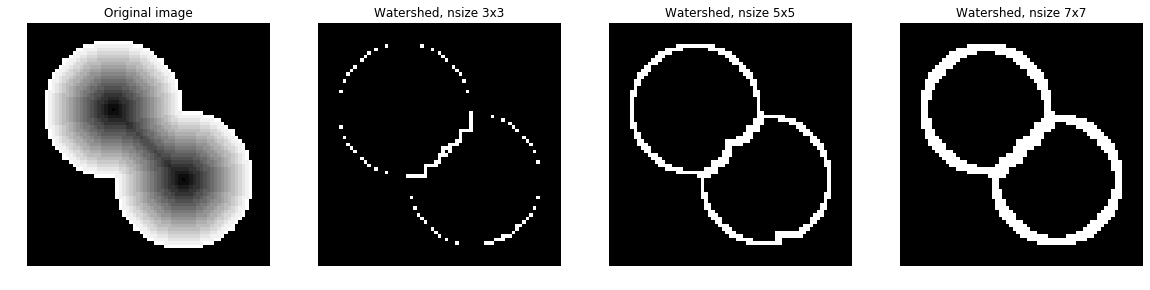

In [32]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage.morphology import distance_transform_edt
%matplotlib inline

def get_neighborhood_indices(shape, x, y, nsize=1):
    indices = np.zeros(shape, dtype=np.bool)
    indices[np.maximum(0,x-nsize):np.minimum(x+nsize+1,shape[0]),
            np.maximum(0,y-nsize):np.minimum(y+nsize+1,shape[1])] = True
    indices[x,y] = False
    
    return indices

def watershed(img, step=1, nsize=1):
    """
    Perform watershed transform on a grayscale image.
    
    Args:
        img: The grayscale image.
        step (int): The rise of the waterlevel at each step. Default 1.
        
    Returns:
        A binary image containing the watersheds.
    """
    NO_LABEL = 0
    WATERSHED = 1
    NEW_LABEL = 2

    label = np.zeros(img.shape, np.uint16)
    
    for h in np.arange(img.min(), img.max(), step):

        count = 0
        
        for x in np.arange(img.shape[0]):
            for y in np.arange(img.shape[1]):
                # Ignore if pixel does not meet requirements
                if img[x,y] > h or label[x,y] != NO_LABEL:
                    continue
                    
                # Get indices of neightbour region, minding the borders
                n_indices = get_neighborhood_indices(img.shape, x, y, nsize)
                # Get neighbor's labels
                n_labels = label[n_indices]
                # Unique labels of pixels already flooded
                flooded = np.unique(n_labels[n_labels > WATERSHED])

                # No pixel in the neighborhood was flooded yet
                if len(flooded) == 0:
                    label[x,y] = NEW_LABEL + count
                    count += 1
                # Homogeneous neighbourhood
                elif len(flooded) == 1:
                    label[x,y] = flooded[0]
                # Heterogeneous neighbourhood
                else:
                    old = flooded[flooded < NEW_LABEL]
                    if len(old) == 0:
                        label[x,y] = NEW_LABEL
                        label[n_indices] = NEW_LABEL
                    elif len(old) == 1:
                        label[x,y] = old[0]
                        label[n_indices] = old[0]
                    else:
                        label[x,y] = WATERSHED

        NEW_LABEL += 1
                
    return np.where(label == WATERSHED, 255, 0)


img = imageio.imread('images/dist_circles.png', pilmode='L')

steps = [1,2,3]

plt.figure(figsize=(20, 5))
plt.gray()
plt.subplot(1,len(steps)+1,1)
plt.title("Original image")
plt.axis('off')
plt.imshow(img)

for i,step in enumerate(steps):
    plt.subplot(1,len(steps)+1,i+2)
    plt.axis('off')
    plt.title("Watershed, nsize {}x{}".format(2*step+1,2*step+1))
    plt.imshow(watershed(img,nsize=step))
    
plt.show()

### c) Application: maze

You can use watershed transform to find your way through a maze. To do so, first apply a distance transform to the maze and the flood the result. The watershed will show you the way through the maze. Explain why this works.

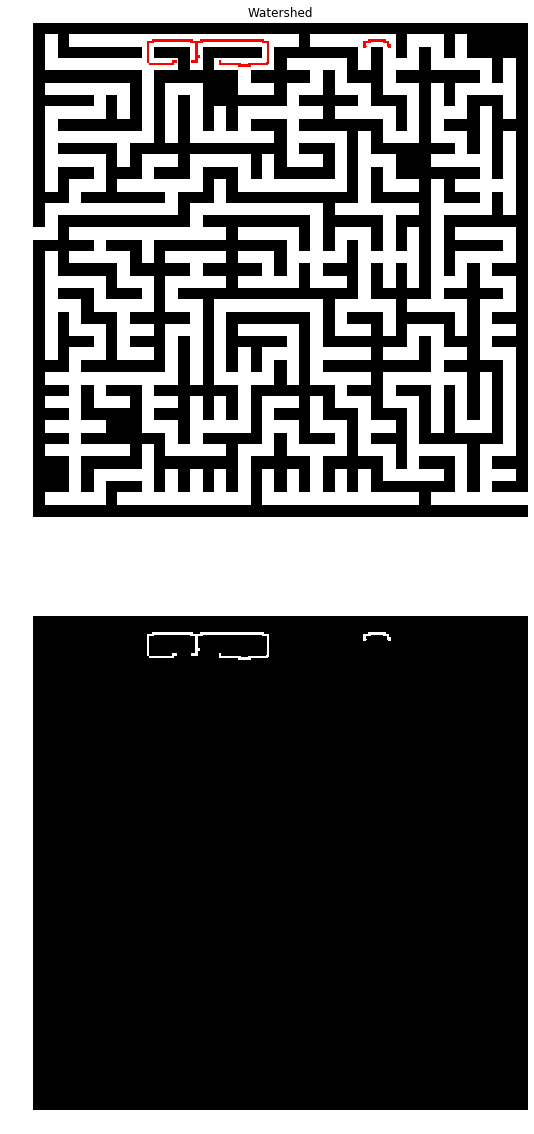

In [33]:
import imageio
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.morphology import distance_transform_edt
%matplotlib inline

img = imageio.imread('images/maze2.png', pilmode = 'L') # 'maze1.png' or 'maze2.png'
result = img[:,:,np.newaxis].repeat(3, 2)
ws = watershed(distance_transform_edt(img),nsize=2)
result[ws > 0] = [255,0,0]

plt.figure(figsize=(10, 20))
plt.subplot(2,1,1)
plt.title('Maze with Watershed')
plt.axis('off')
plt.imshow(result)

plt.title('Watershed')
plt.subplot(2,1,2)
plt.axis('off')
plt.imshow(ws)
plt.show()

YOUR ANSWER HERE

## Assignment 3: $k$-means segmentation [5 Points]


**a)** Explain the idea of $k$-means clustering and how it can be used for segmentation.

**k**-means clustering tries to find the k best fitting clusters in a data set. It starts out with every datum as one cluster and iteratively merges clusters with minimal distance to each other (different metrics yield different results).

**b)** Implement k-means clustering for color segmentation of an RGB image (no use of `scipy.cluster.vq.kmeans` or similar functions allowed here, but you may use functions like `numpy.mean`, `scipy.spatial.distance.pdist` and similar utility functions). Stop calculation when center vectors do not change more than a predefined threshold. Avoid empty clusters by re-initializing the corresponding center vector. (Empirically) determine a good value for $k$ for clustering the image 'peppers.png'.
**Bonus** If you want you can visualize the intermediate steps of the clustering process.

First lets take a look at how our image looks in RGB colorspace. 

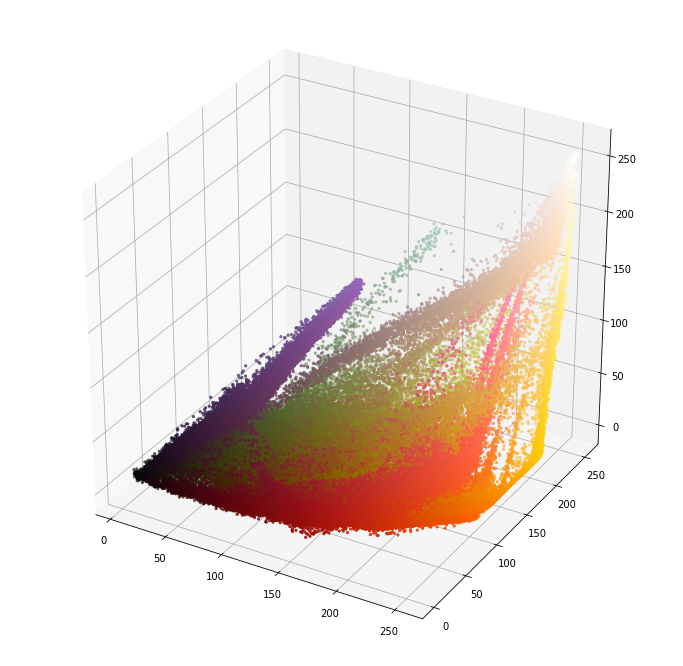

In [34]:
from mpl_toolkits.mplot3d import Axes3D
from skimage import io
import matplotlib.pyplot as plt
%matplotlib inline

img = io.imread('images/peppers.png')
vec = img.reshape((-1, img.shape[2]))
vec_scaled = vec / 255
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')
ret = ax.scatter(vec[:, 0], vec[:, 1], vec[:, 2], c=vec_scaled, marker='.')

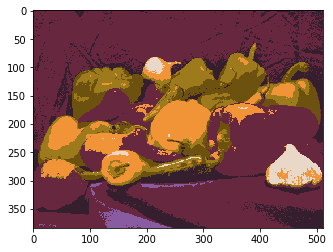

In [239]:
import numpy as np
from scipy.spatial import distance
from IPython import display
from skimage import io, measure, color
import time
import matplotlib.pyplot as plt
%matplotlib inline

def cluster_image(img,cluster,centers):
    for i in np.arange(centers.shape[0]):
        img[cluster == i] = centers[i]
    return img

def batch_euclid(X,Y,channels):
    return np.sqrt(np.sum(np.square(X[:,channels] - Y[:,channels]), axis=1))


def kmeans_rgb(img, k, threshold=0, channels=[0,1,2], do_display=False):
    """
    k-means clustering in RGB space.

    Arguments:
        img (numpy.ndarray): an RGB image
        k (int): the number of clusters
        threshold (float): Maximal change for convergence criterion.
        do_display (bool): Whether or not to plot, intermediate steps.
        
    Result:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    iteration = 0
    change = 0

    centers = np.random.uniform(low=img.min(), high=img.max(), size=(k,3)) 
    cluster = np.empty((img.shape[0],img.shape[1]), dtype=np.uint16)
    img_flat = np.reshape(img, (img.shape[0]*img.shape[1], 3))
    
    while True:
        # Assign best matching cluster center
        distances = distance.cdist(img_flat, centers)
        cluster = np.argmin(distances, axis=1).reshape((img.shape[0],img.shape[1]))
        
        # Shift cluster centers to mean
        previous = centers.copy()
        for i in np.arange(k):
            if not np.any(cluster == i):
                centers[i,:] = np.random.uniform(img.min(), img.max(), 3)
            else:
                centers[i,:] = img[cluster == i].mean(axis=0)
        
        change = np.amax(batch_euclid(centers, previous, channels))
        if change >= threshold or iteration >= 1000:
            break;
        iteration += 1
    
    return cluster, centers

img = io.imread('images/peppers.png', pilmode = 'RGB')

cluster, centers = kmeans_rgb(img, k=7, threshold=0, do_display=True)
    
plt.imshow(cluster_image(img, cluster, centers))
plt.show()

**c)** Now do the same in the HSV space (remember its special topological structure). Check if you can improve the results by ignoring some of the HSV channels.

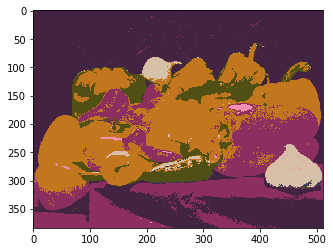

In [242]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from scipy import spatial

%matplotlib inline
# from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

img = imageio.imread('images/peppers.png', pilmode = 'RGB')

def kmeans_hsv(img, k, threshold=0):
    """
    k-means clustering in HSV space.

    Arguments:
        img (numpy.ndarray): an HSV image
        k (int): the number of clusters
        threshold (float): 
        
    Result:
        cluster (numpy.ndarray): an array of the same size as `img`,
            containing for each pixel the cluster it belongs to
        centers (numpy.ndarray): an array
    """
    return kmeans_rgb(img, k, threshold, channels=np.array([0,2]))


img_hsv = color.rgb2hsv(img)
k = 7
theta = 0.01

cluster, centers_hsv = kmeans_hsv(img_hsv, k, theta)
plt.imshow(color.hsv2rgb(cluster_image(img_hsv, cluster, centers_hsv)))
plt.show()

## Assignment 4: Interactive Region Growing [5 Points]

Implement flood fill as described in (CV07 slides 123ff.).


The function `on_press` is called when a mouse button is pressed inside the canvas. From there call `floodfill`. Use the filtered hsv image `img_filtered` for your computation, and show the computed region around the seed point (the position where the mousebutton was pressed) in the original image. You may use a mask to save which pixels belong the the region (and to save which pixels you already visited). 

Hint: If you can not see the image, try restarting the kernel.

<IPython.core.display.Javascript object>


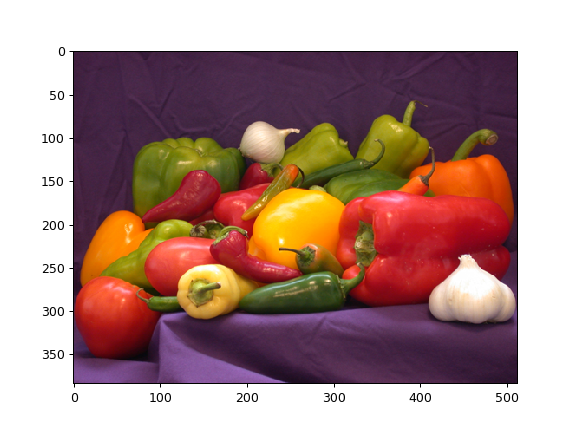

In [3]:
%matplotlib notebook
import imageio
import math
import numpy as np
from matplotlib import pyplot as plt
from skimage import color
import scipy.ndimage as ndimage
from sys import setrecursionlimit

threshold = 0.25 #.08;

setrecursionlimit(10000)

img = imageio.imread('images/peppers.png')
img_hsv = color.rgb2hsv(img)
img_filtered = ndimage.median_filter(img_hsv, 5)

def floodfill(img, mask, x, y, color):
    """Recursively grows region around seed point
    
    Args: 
        img: The image in which the region is grown
        mask: Boolean ndarray in which visited pixels which belong to the
                region are saved
        x: X coordinate of the pixel. Checks if this pixels belongs to the region
        y: Y coordinate of the pixel.
        color: The color at the seed position
    """
    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1] and \
        np.absolute(img[x,y,0]-color[0]) < threshold:
        # If we were already here, stop (recursion anchor)
        if mask[x,y]:
            return
        # Set visited
        mask[x,y] = True
        # Set color
        img[x,y] = color
        # Call for 8-neighborhood
        floodfill(img, mask, x+1, y, color)
        floodfill(img, mask, x-1, y, color)
        floodfill(img, mask, x, y+1, color)
        floodfill(img, mask, x, y-1, color)
        floodfill(img, mask, x+1, y+1, color)
        floodfill(img, mask, x-1, y+1, color)
        floodfill(img, mask, x-1, y+1, color)
        floodfill(img, mask, x-1, y-1, color)

def on_press(event):
    """Mouse button press event handler
    
    Args:
        event: The mouse event
    """
    y = math.floor(event.xdata)
    x = math.floor(event.ydata)
    color = img_filtered[x, y, :]
    mask = np.zeros(img_filtered.shape[0]*img_filtered.shape[1],dtype=np.bool)
    mask[x,y] = True
    floodfill(img_filtered, mask, x, y, color)
    fig.canvas.draw()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.imshow(img)

fig.canvas.mpl_connect('button_press_event', on_press)

plt.show()